In [ ]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from google.colab import files
from sklearn.metrics import classification_report,confusion_matrix


Getting the data from kaggle directly

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yaminighananjani","key":"497180f96109dcd7c098a386c9e227a0"}'}

In [ ]:
# key requisite for the API key to work
# make sure that the kaggle enviornment and the json file are in the same enviornment
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

In [ ]:
 !kaggle datasets download -d sid321axn/covid-cxr-image-dataset-research

 99% 568M/572M [00:07<00:00, 121MB/s]
100% 572M/572M [00:07<00:00, 84.9MB/s]


In [ ]:
!unzip \*.zip

Archive:  covid-cxr-image-dataset-research.zip
  inflating: COVID_IEEE/covid/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg  
  inflating: COVID_IEEE/covid/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg  
  inflating: COVID_IEEE/covid/1-s2.0-S0140673620303706-fx1_lrg.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-c.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-d.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-001.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-002.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a2.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-003-b1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-003-b2.pn

understanding the structure of data

In [ ]:
for dirpath,dirname,filename in os.walk("/content/COVID_IEEE"):
  print(f"there are {len(dirname)} directory and {len(filename)} image in '{dirpath}.")

there are 3 directory and 0 image in '/content/COVID_IEEE.
there are 0 directory and 668 image in '/content/COVID_IEEE/normal.
there are 0 directory and 619 image in '/content/COVID_IEEE/virus.
there are 0 directory and 536 image in '/content/COVID_IEEE/covid.


In [ ]:
data_dir = pathlib.Path("/content/COVID_IEEE")

storing the name of the above folders as they will become our target variables

In [ ]:
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['covid', 'normal', 'virus'], dtype='<U6')

Creating a function that will randomly import a image from a specified folder from the given directory

In [ ]:
def view_image(target_dir, target_class):
    target_folder = target_dir+target_class
    random_image = random.sample(os.listdir(target_folder),1) #no of images we have to pick in this case 1
    print(random_image)
    img = mpimg.imread(target_folder+"/"+ random_image[0]) #reading the matplot image then pass the target folder and then / and then define the random image
    plt.imshow(img, cmap ="gray")
    plt.title(target_class)#define the variable for which class it belongs
    plt.axis("off")
    print(f"image shape {img.shape}")

    return img


['person434_virus_883.jpeg']
image shape (1288, 1456)


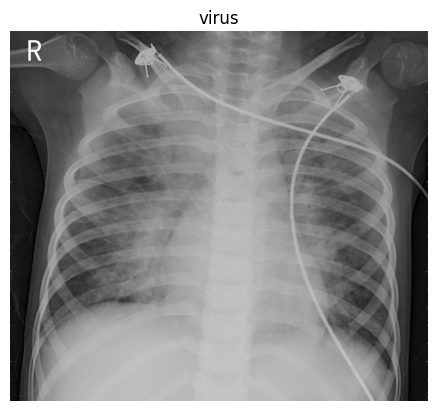

In [ ]:
img = view_image("/content/COVID_IEEE/","virus")

['NORMAL2-IM-0868-0001.jpeg']
image shape (1283, 1504)


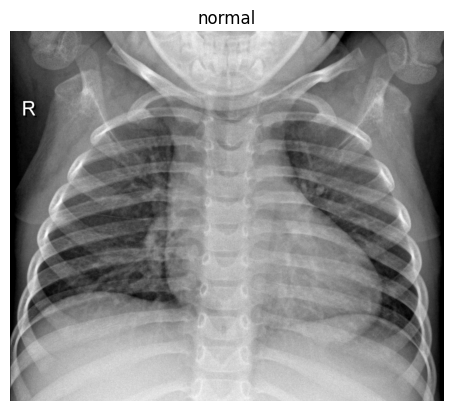

In [ ]:
img = view_image("/content/COVID_IEEE/","normal")

['figure1-5e75d0940b71e1b702629659-98-right.jpeg']
image shape (982, 1261, 3)


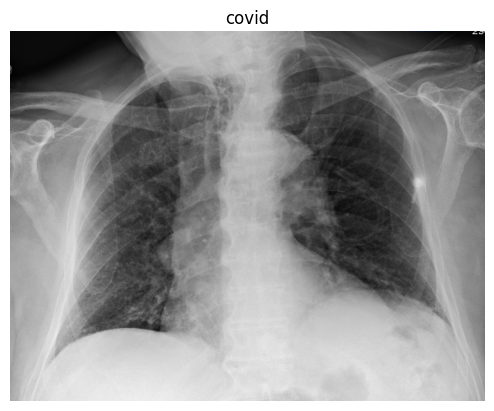

In [ ]:
img = view_image("/content/COVID_IEEE/","covid")

storing the images in te form of numpy images

In [ ]:
data=[] # to store images in array
labels=[] # to store labels in array
covid=os.listdir("/content/COVID_IEEE/covid/") #load images

#for loop to iterate over the images
for a in covid:

    image = cv2.imread("/content/COVID_IEEE/covid/"+a,) # default path + add the image name
    image = cv2.resize(image, (224, 224))

    data.append(image)
    labels.append(0)

In [ ]:
normal=os.listdir("/content/COVID_IEEE/normal/")
for a in normal:

    image = cv2.imread("/content/COVID_IEEE/normal/"+a,)
    image = cv2.resize(image, (224, 224))



    data.append(image)
    labels.append(1)

In [ ]:
virus=os.listdir("/content/COVID_IEEE/virus/")
for a in virus:

    image = cv2.imread("/content/COVID_IEEE/virus/"+a,)
    image = cv2.resize(image, (224, 224))


    data.append(image)
    labels.append(2)

In [ ]:
#converting into numpy array and normalize the data
#to normalize the data we are dividing the array with the highest pixel value
data = np.array(data) / 255.0
img_labels = np.array(labels)

In [ ]:
data

array([[[[0.72156863, 0.72156863, 0.72156863],
         [0.70980392, 0.70980392, 0.70980392],
         [0.70980392, 0.70980392, 0.70980392],
         ...,
         [0.58431373, 0.58431373, 0.58431373],
         [0.58823529, 0.58823529, 0.58823529],
         [0.58823529, 0.58823529, 0.58823529]],

        [[0.37647059, 0.37647059, 0.37647059],
         [0.32941176, 0.32941176, 0.32941176],
         [0.30588235, 0.30588235, 0.30588235],
         ...,
         [0.07058824, 0.07058824, 0.07058824],
         [0.07058824, 0.07058824, 0.07058824],
         [0.07058824, 0.07058824, 0.07058824]],

        [[0.03137255, 0.03137255, 0.03137255],
         [0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         ...,
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157]],

        ...,

        [[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157]

In [ ]:
#test if the model is performing on the training data correctly
X_train, X_test, y_train, y_test = train_test_split(data, img_labels, test_size=0.20, random_state=42)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3) # one hot encoding
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)


BUILDING THE MODEL

In [ ]:
model = Sequential()

#Block Number 1
model.add(Conv2D(input_shape = (224,224,3), filters=32,padding="same", kernel_size= (3,3))) #adding conv layer to extract the feature from the images
model.add(Activation("relu")) # USED FOR INTRODUCING NON LINEARITY OF THE MODEL

model.add(Conv2D(filters=32,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))# Reducing the size of the feature map

#Block Number 2
model.add(Conv2D(filters=64,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))


model.add(Conv2D(filters=64,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))

#Block Number 3
model.add(Conv2D(filters=128,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=128,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))

model.add(MaxPool2D((2,2)))

# Fully Connected layer
model.add(Flatten())

model.add(Dense(units=1024, activation="relu"))

model.add(Dense(units=256, activation="relu"))


model.add(Dense(units=3, activation="softmax"))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                        

In [ ]:
model.fit(X_train, y_train, validation_split=0.3, epochs=15, batch_size=32)

Epoch 1/15
32/32 [==============================] - 285s 9s/step - loss: 1.0625 - accuracy: 0.5735 - val_loss: 0.6122 - val_accuracy: 0.6986
Epoch 2/15
32/32 [==============================] - 279s 9s/step - loss: 0.4579 - accuracy: 0.8294 - val_loss: 0.2993 - val_accuracy: 0.8950
Epoch 3/15
32/32 [==============================] - 293s 9s/step - loss: 0.3212 - accuracy: 0.8902 - val_loss: 0.2683 - val_accuracy: 0.9041
Epoch 4/15
32/32 [==============================] - 304s 9s/step - loss: 0.2574 - accuracy: 0.9118 - val_loss: 0.1975 - val_accuracy: 0.9247
Epoch 5/15
32/32 [==============================] - 299s 9s/step - loss: 0.2104 - accuracy: 0.9294 - val_loss: 0.1417 - val_accuracy: 0.9475
Epoch 6/15
32/32 [==============================] - 283s 9s/step - loss: 0.1401 - accuracy: 0.9510 - val_loss: 0.1446 - val_accuracy: 0.9498
Epoch 7/15
32/32 [==============================] - 287s 9s/step - loss: 0.1385 - accuracy: 0.9471 - val_loss: 0.1654 - val_accuracy: 0.9384
Epoch 8/15
32

Visulaize the code

Text(0.5, 1.0, 'Training-Validation Accuracy')

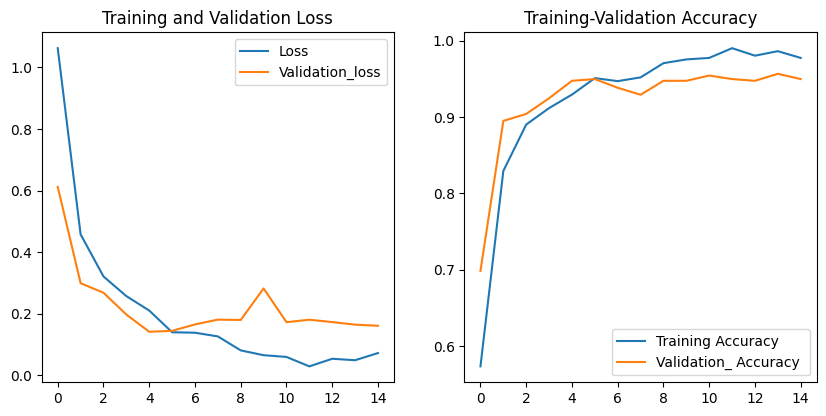

In [ ]:
#saving the model history
loss = pd.DataFrame(model.history.history)

#plotting the loss and accuracy
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(loss["loss"], label ="Loss")
plt.plot(loss["val_loss"], label = "Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(2,2,2)
plt.plot(loss['accuracy'],label = "Training Accuracy")
plt.plot(loss['val_accuracy'], label ="Validation_ Accuracy ")
plt.legend()
plt.title("Training-Validation Accuracy")

classification report of the predicted values of how the model is doing in each class

In [ ]:

predictions = model.predict(X_test)

y_pred = np.argmax(predictions, axis = 1)
y_test_new = np.argmax(y_test, axis = 1) #argmax function - to reformat -finding the class with the highest predicted probability

12/12 [==============================] - 22s 2s/step


In [ ]:
print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       108
           1       0.89      0.97      0.93       129
           2       0.96      0.92      0.94       128

    accuracy                           0.94       365
   macro avg       0.94      0.94      0.94       365
weighted avg       0.94      0.94      0.94       365



In [ ]:
pd.DataFrame(confusion_matrix(y_test_new, y_pred), columns= ["covid", "normal", "virus"], index = ["covid", "normal", "virus"])

,covid,normal,virus
covid,99,7,2
normal,1,125,3
virus,2,8,118


import numpy as np
from google.colab import autoviz
df_4438740966878371090 = autoviz.get_df('df_4438740966878371090')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_4438740966878371090, *['covid'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4438740966878371090 = autoviz.get_df('df_4438740966878371090')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_4438740966878371090, *['normal'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4438740966878371090 = autoviz.get_df('df_4438740966878371090')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_4438740966878371090, *['virus'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4438740966878371090 = autoviz.get_df('df_4438740966878371090')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_4438740966878371090, *['covid'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4438740966878371090 = autoviz.get_df('df_4438740966878371090')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_4438740966878371090, *['normal'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4438740966878371090 = autoviz.get_df('df_4438740966878371090')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_4438740966878371090, *['virus'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4438740966878371090 = autoviz.get_df('df_4438740966878371090')

def categorical_histogram(df, colname, figsize=(2, 1.2), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  _, ax = plt.subplots(figsize=figsize)
  bars = df[colname].value_counts()
  plt.barh(bars.index, bars.values, color=sns.palettes.mpl_palette(mpl_palette_name))
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df_4438740966878371090, *['index'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4438740966878371090 = autoviz.get_df('df_4438740966878371090')

def scatter_plots(df, colname_pairs, scatter_plot_size=2.5, size=8, alpha=.6):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * scatter_plot_size, scatter_plot_size))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    ax.scatter(df[x_colname], df[y_colname], s=size, alpha=alpha)
    plt.xlabel(x_colname)
    plt.ylabel(y_colname)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df_4438740966878371090, *[[['covid', 'normal'], ['normal', 'virus']]], **{})
chart

import numpy as np
from google.colab import autoviz
df_4438740966878371090 = autoviz.get_df('df_4438740966878371090')

def violin_plot(df, value_colname, facet_colname, col_width=.3, col_length=3, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(col_length, col_width * len(df[facet_colname].unique())))
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_4438740966878371090, *['covid', 'index'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz
df_4438740966878371090 = autoviz.get_df('df_4438740966878371090')

def violin_plot(df, value_colname, facet_colname, col_width=.3, col_length=3, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(col_length, col_width * len(df[facet_colname].unique())))
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_4438740966878371090, *['normal', 'index'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz
df_4438740966878371090 = autoviz.get_df('df_4438740966878371090')

def violin_plot(df, value_colname, facet_colname, col_width=.3, col_length=3, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(col_length, col_width * len(df[facet_colname].unique())))
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_4438740966878371090, *['virus', 'index'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz
df_4438740966878371090 = autoviz.get_df('df_4438740966878371090')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_4438740966878371090, *['virus', 'covid', 'index'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4438740966878371090 = autoviz.get_df('df_4438740966878371090')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_4438740966878371090, *['virus', 'normal', 'index'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4438740966878371090 = autoviz.get_df('df_4438740966878371090')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_4438740966878371090, *['virus', 'count()', 'index'], **{})
chart

USINF PRETRAINED MODEL USING TRANSFER LEANING

In [ ]:
base_model = tf.keras.applications.MobileNet(input_shape=[224,224,3], weights = "imagenet", include_top=False)

for layer in base_model.layers:
  layer.trainable =False  #Freezing the weights of network as if this is not done then the weights of the network will start changing with time and the whole purpose of transfer learning will be defeated


In [ ]:

model = Flatten()(base_model.output)

model = Dense(units=1024, activation="relu")(model)
model = Dense(units=512, activation="relu")(model)
model = Dense(units=256, activation="relu")(model)

prediction_layer = Dense(units=3, activation="softmax")(model)


In [ ]:

model = Model(inputs = base_model.input, outputs = prediction_layer)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [ ]:
model.summary()

                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_10 (DepthwiseConv2D  (None, 14, 14, 512)      4608      
 )                                                               
          

In [ ]:
model.fit(X_train, y_train, validation_split=0.3, epochs=15, batch_size=32)

Epoch 1/15
32/32 [==============================] - 71s 2s/step - loss: 10.3537 - accuracy: 0.7686 - val_loss: 0.3090 - val_accuracy: 0.9658
Epoch 2/15
32/32 [==============================] - 62s 2s/step - loss: 0.6211 - accuracy: 0.9471 - val_loss: 0.4499 - val_accuracy: 0.9543
Epoch 3/15
32/32 [==============================] - 63s 2s/step - loss: 0.2531 - accuracy: 0.9716 - val_loss: 0.3391 - val_accuracy: 0.9635
Epoch 4/15
32/32 [==============================] - 55s 2s/step - loss: 0.0991 - accuracy: 0.9833 - val_loss: 0.7625 - val_accuracy: 0.9498
Epoch 5/15
32/32 [==============================] - 62s 2s/step - loss: 0.1206 - accuracy: 0.9814 - val_loss: 0.5767 - val_accuracy: 0.9338
Epoch 6/15
32/32 [==============================] - 55s 2s/step - loss: 0.3541 - accuracy: 0.9637 - val_loss: 0.6705 - val_accuracy: 0.9589
Epoch 7/15
32/32 [==============================] - 63s 2s/step - loss: 0.1592 - accuracy: 0.9892 - val_loss: 0.8406 - val_accuracy: 0.9498
Epoch 8/15
32/32 [=

Text(0.5, 1.0, 'Training-Validation Accuracy')

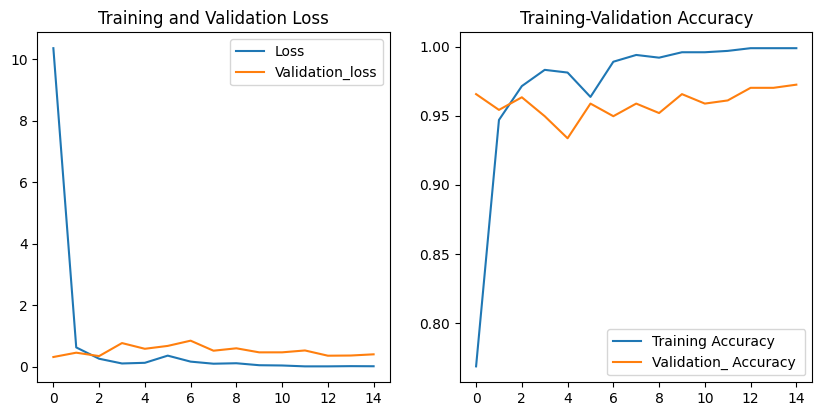

In [ ]:
#saving the model history
loss = pd.DataFrame(model.history.history)

#plotting the loss and accuracy
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(loss["loss"], label ="Loss")
plt.plot(loss["val_loss"], label = "Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(2,2,2)
plt.plot(loss['accuracy'],label = "Training Accuracy")
plt.plot(loss['val_accuracy'], label ="Validation_ Accuracy ")
plt.legend()
plt.title("Training-Validation Accuracy")


In [ ]:
predictions = model.predict(X_test)

y_pred = np.argmax(predictions, axis = 1)
y_test_new = np.argmax(y_test, axis = 1)

12/12 [==============================] - 12s 859ms/step


In [ ]:

print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98       108
           1       0.96      0.98      0.97       129
           2       0.95      0.96      0.95       128

    accuracy                           0.97       365
   macro avg       0.97      0.97      0.97       365
weighted avg       0.97      0.97      0.97       365



In [ ]:
pd.DataFrame(confusion_matrix(y_test_new, y_pred), columns= ["covid", "normal", "virus"], index = ["covid", "normal", "virus"])


,covid,normal,virus
covid,103,0,5
normal,0,127,2
virus,0,5,123
